![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)


![GA_image](https://www.mdmantenimientoweb.com/wp-content/uploads/2020/03/Google_Analytics_05-2016.png)



# Google Analytics -  Customer Revenue Prediction

## Table of Contents

* [A. Introduction](#introduction)
    * [A1. What is Google Analytics?](#google_analytics)
    * [A2. The problem](#intro_problem)
* [B. Importing Libraries](#libraries)
* [C. Importing data](#data)


* [2. MLC2: Data understanding](#data_understanding)
    * [2.1. MLC2.1.: Univariate data analysis](#univariate_data_analysis)
        * [2.1.1. Dataset size](#dataset_size)
        * [2.1.2. Direct visualization of the data](#direct_visualization)
        * [2.1.3. Variable types](#variable_types)
        * [2.1.4. Descriptive statistics](#descriptive_statistics)
        * [2.1.5. Null values](#null_values)
        * [2.1.6. Distribution of target](#target_distribution)
        * [2.1.7-2.1.10. Variables distribution & relations with target](#variables_distribution)
            * [a) Categorical variables](#variables_distribution_categorical)
            * [b) Numerical variables](#variables_distribution_numerical)

  
        
* [3. MLC3: Data preparation](#data_preparation)
    * [3.1. MLC 3.1. Data cleaning](#data_cleaning)
        * [3.1.1. Dealing with variable types](#dealing_variable_types)
        * [3.1.2. Imputation of null values](#nulls_imputation)
        * [3.1.4. Elimination of features with low variance](#low_variance)
    * [3.2. MLC 3.2. Data transformation](#data_transformation)
        * [3.2.1. Transformation of categorical variables](#data_transformation_categorical)
        * [3.2.2. Transformation of date variables](#data_transformation_date)
        * [3.2.3. Transformation of numerical variables](#data_transformation_numerical)
    * [3.3. MLC 3.3. Feature engineering](#feature_engineering)


* [4. MLC4: Modelling](#modelling)
    * [4.1. MLC 4.1. Data partition and sampling](#dataset_partition)
    * [4.2. MLC 4.2. Model definition](#model_definition)
        * [4.2.a Linear Regression](#linear_regression)
        * [4.2.b Gradient Boosting](#xgboost)
        * [4.2.c Gradient Boosting with undersampling](#xgboost_under)

* [5. MLC5: Evaluation](#model_evaluation)






## A. Introduction <a class="anchor" id="introduction"></a>

### A1. What is Google Analytics?<a class="anchor" id="google_analytics"></a>

Google Analytics is one of the many tools that Google provides to help people understand what visitors are doing on their website. The tool allows you to track and analyze critical data on your site and site visitors. 

The first element of Google Analytics is data collection. The platform can gather a broad range of data about your site and how visitors use it. The exact nature of the data collected will be discussed in depth later. It includes, most notably:

    - How many visitors your pages get.
    - Where visitors come to your pages from.
    - How those visitors progress through your site.
    - What visitors do on your pages.
    - How visitors interact with elements on your pages.
    - How long visitors spend on your pages.
    - At what stage of a visit users leave your site.
    
More info in https://marketingplatform.google.com/intl/en_uk/about/analytics/

### A2. The problem<a class="anchor" id="intro_problem"></a>

The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.

Your objective is to analyze the Google Analytics data of the web store from the company and to develop a machine learning model to predict revenue per customer.

The problem has been taken from the following Kaggle competition: https://www.kaggle.com/c/ga-customer-revenue-prediction/overview

## B. Importing libraries<a class="anchor" id="libraries"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # Series and DataFrames

# import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## new libraries
import random
import json
from pandas.io.json import json_normalize
import os 

## others
from datetime import datetime
from scipy import stats
import time

# from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_rows', 500)
#pd.options.display.float_format = '{:,.2f}'.format

In [2]:
## for the modeling
from sklearn import model_selection
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb

In [3]:
#!pip install jupyter_contrib_nbextensions
#!jupyter contrib nbextension install --user
#!jupyter nbextension enable spellchecker/main

In [4]:
### Seed to get same results
RANDOM_STATE = 42

## C. Importing data<a class="anchor" id="data"></a>

In [5]:
### Data paths and directories
file_dir = 'data/'
file_name = 'GACR_dataset.csv'
subsample_file_name = 'GACR_dataset_sample_15.csv'



We'll carry out a first EDA over a 15% of the dataset (for speed reasons). If we are limited by memory, it makes sense to carry out a first EDA over a randomly selected fraction of our dataset, and to extend it in a second stage to the whole dataset

Let's import the dataset using the provided function

**Useful command: '%%time':** %%time is a magic command, which is part of IPython. %%time prints the wall time for the entire cell (%time gives you the time for first line only). Using %%time or %time prints 2 values:

    - CPU Times
    - Wall Time

In [236]:
%%time
df = pd.read_csv(file_dir + subsample_file_name)
print("Shape of the 15% subsample: ",df.shape)

Shape of the 15% subsample:  (135547, 32)
CPU times: user 671 ms, sys: 32.6 ms, total: 703 ms
Wall time: 707 ms


In [238]:
df.columns

Index(['Unnamed: 0', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'device.browser',
       'device.browserVersion', 'device.browserSize', 'device.operatingSystem',
       'device.operatingSystemVersion', 'device.mobileDeviceBranding',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.flashVersion', 'device.language', 'device.screenColors',
       'device.screenResolution', 'geoNetwork.continent', 'geoNetwork.cityId',
       'geoNetwork.latitude', 'geoNetwork.longitude',
       'geoNetwork.networkLocation', 'totals.visits', 'totals.hits',
       'totals.pageviews', 'totals.bounces', 'totals.newVisits',
       'totals.transactionRevenue'],
      dtype='object')

## MLC2: Data Understanding<a class="anchor" id="data_understanding"></a>

## MLC2.1: Univariate data analysis<a class="anchor" id="univariate_data_analysis"></a>



### 2.1.1. Dataset size<a class="anchor" id="dataset_size"></a>

**df.info()** allows to explore the basic information of the dataset

In [11]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135547 entries, 0 to 135546
Columns: 31 entries, date to totals.transactionRevenue
dtypes: float64(4), int64(5), object(21), uint64(1)
memory usage: 32.1+ MB


**df.shape** returns the numbers of rows and columns of the dataframe

In [12]:
df.shape

(135547, 31)

### 2.1.2.  Direct visualization of the data<a class="anchor" id="direct_visualization"></a>


we should be already very familiar with the **head** command

In [13]:
df.head().T

,0,1,2,3,4
date,20170331,20170717,20170602,20170528,20170726
fullVisitorId,544964540242051041,5317887555212111581,2494424733344070750,5122857189400199535,6826136518561551939
sessionId,0544964540242051041_1490971283,5317887555212111581_1500327373,2494424733344070750_1496401320,5122857189400199535_1495978490,6826136518561551939_1501081796
socialEngagementType,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged
visitId,1490971283,1500327373,1496401320,1495978490,1501081796
visitNumber,2,1,3,1,1
device.browser,UC Browser,Chrome,Chrome,Chrome,Chrome
device.browserVersion,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset
device.browserSize,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset
device.operatingSystem,Android,Macintosh,Android,Android,Macintosh


**df.columns** prints the list of columns in the dataset

In [14]:
df.columns

Index(['date', 'fullVisitorId', 'sessionId', 'socialEngagementType', 'visitId',
       'visitNumber', 'device.browser', 'device.browserVersion',
       'device.browserSize', 'device.operatingSystem',
       'device.operatingSystemVersion', 'device.mobileDeviceBranding',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.flashVersion', 'device.language', 'device.screenColors',
       'device.screenResolution', 'geoNetwork.continent', 'geoNetwork.cityId',
       'geoNetwork.latitude', 'geoNetwork.longitude',
       'geoNetwork.networkLocation', 'totals.visits', 'totals.hits',
       'totals.pageviews', 'totals.bounces', 'totals.newVisits',
       'totals.transactionRevenue'],
      dtype='object')

Here is the available information explaining  the main variable in the dataset:

* **fullVisitorId** - A unique identifier for each user of the Google Merchandise Store.
* **date** - The date on which the user visited the Store.
* **device** - The specifications for the device used to access the Store.
* **geoNetwork** - This section contains information about the geography of the user.
* **socialEngagementType** - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
* **totals** - This section contains aggregate values across the session.
* **trafficSource** - This section contains information about the Traffic Source from which the session originated.
* **visitId** - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
* **visitNumber** - The session number for this user. If this is the first session, then this is set to 1.
* **hits - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.
* **sessionId** - A unique identifier for this visit to the store.
* **customDimensions** - This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.
* **totals** - This set of columns mostly includes high-level aggregate data.


We are setting the sessionId as the index of our dataframe for the time being (unique id). Let's verify that different registers have different sessionID values 

In [15]:
print(df.shape)
print(df[['sessionId']].drop_duplicates().shape)

(135547, 31)
(135533, 1)


There seem to be a few duplicated sessionIds in the data. Why is that? We'll ignore it here, but you need to look into it! 

We are setting the sessionId as index anyway 

In [16]:
df.set_index('sessionId', inplace=True)

In [17]:
df.head(2).T

sessionId,0544964540242051041_1490971283,5317887555212111581_1500327373
date,20170331,20170717
fullVisitorId,544964540242051041,5317887555212111581
socialEngagementType,Not Socially Engaged,Not Socially Engaged
visitId,1490971283,1500327373
visitNumber,2,1
device.browser,UC Browser,Chrome
device.browserVersion,not available in demo dataset,not available in demo dataset
device.browserSize,not available in demo dataset,not available in demo dataset
device.operatingSystem,Android,Macintosh
device.operatingSystemVersion,not available in demo dataset,not available in demo dataset


and we are excluding ['fullVisitorId', 'visitId'], as sessionId is a combination of both, and we won't be looking at a user level. If we were predicting which users are more likely to buy something, the fullVisitorId would be essential in the training data

In [18]:
df_ids = ['fullVisitorId', 'visitId']
df.drop(df_ids, axis=1, inplace=True)

### 2.1.3. Types of variables available<a class="anchor" id="variable_types"></a>

To explore the variable types in our dataframe we have at least two options: the **info()** function (specifying the parameter *verbose = True*) or using **dtypes**

In [19]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 135547 entries, 0544964540242051041_1490971283 to 4632817159671077343_1481397815
Data columns (total 28 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   date                              135547 non-null  int64  
 1   socialEngagementType              135547 non-null  object 
 2   visitNumber                       135547 non-null  int64  
 3   device.browser                    135547 non-null  object 
 4   device.browserVersion             135547 non-null  object 
 5   device.browserSize                135547 non-null  object 
 6   device.operatingSystem            135547 non-null  object 
 7   device.operatingSystemVersion     135547 non-null  object 
 8   device.mobileDeviceBranding       135547 non-null  object 
 9   device.mobileDeviceModel          135547 non-null  object 
 10  device.mobileInputSelector        135547 non-null  object 
 11  devi

In [20]:
df.dtypes

date                                  int64
socialEngagementType                 object
visitNumber                           int64
device.browser                       object
device.browserVersion                object
device.browserSize                   object
device.operatingSystem               object
device.operatingSystemVersion        object
device.mobileDeviceBranding          object
device.mobileDeviceModel             object
device.mobileInputSelector           object
device.mobileDeviceInfo              object
device.mobileDeviceMarketingName     object
device.flashVersion                  object
device.language                      object
device.screenColors                  object
device.screenResolution              object
geoNetwork.continent                 object
geoNetwork.cityId                    object
geoNetwork.latitude                  object
geoNetwork.longitude                 object
geoNetwork.networkLocation           object
totals.visits                   

### 2.1.4. Descriptive statistics<a class="anchor" id="descriptive_statistics"></a>



In [21]:
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
date,135547.0,2.016588e+07,4.697787e+03,20160801.0,20161026.0,20170108.0,20170420.0,2.017080e+07
visitNumber,135547.0,2.238508e+00,8.915600e+00,1.0,1.0,1.0,1.0,3.840000e+02
totals.visits,135547.0,1.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,1.000000e+00
totals.hits,135547.0,4.564026e+00,9.442314e+00,1.0,1.0,2.0,4.0,5.000000e+02
totals.pageviews,135536.0,3.828931e+00,6.891166e+00,1.0,1.0,1.0,4.0,3.510000e+02
totals.bounces,67687.0,1.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,1.000000e+00
totals.newVisits,105779.0,1.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,1.000000e+00
totals.transactionRevenue,1663.0,1.203300e+08,3.005372e+08,200000.0,24675000.0,45660000.0,99835000.0,8.677830e+09


date is not really numerical, right? We'll deal with that later

In [22]:
df.describe(exclude=np.number).T

,count,unique,top,freq
socialEngagementType,135547,1,Not Socially Engaged,135547
device.browser,135547,30,Chrome,93125
device.browserVersion,135547,1,not available in demo dataset,135547
device.browserSize,135547,1,not available in demo dataset,135547
device.operatingSystem,135547,15,Windows,52746
device.operatingSystemVersion,135547,1,not available in demo dataset,135547
device.mobileDeviceBranding,135547,1,not available in demo dataset,135547
device.mobileDeviceModel,135547,1,not available in demo dataset,135547
device.mobileInputSelector,135547,1,not available in demo dataset,135547
device.mobileDeviceInfo,135547,1,not available in demo dataset,135547


When looking at the output from **describe** we can already appreciate a few things:
*	Variables with null values (we can already see some in the numeric features)
*	Columns with only one value (o variance), non relevant for the modeling
*	Columns with “not available in demo dataset”
*	Top values and their frequencies 
*	Categorical variables for which one-hot encoding probably will not make much sense (too many values)


### 2.1.5. Number/fractions of null values<a class="anchor" id="null_values"></a>

The **describe** function allows to see which variables do contain null values in their distribution (total-count>0). A more straightforward alternative is the method **isnull()**, which returns a matrix indicating whether each element of the DatraFrame is a null value. Counting nulls per column is a matter of summing over across columns. 

Let's do it independently for numeric and categorical columns.  

In [23]:
df.select_dtypes(include=['number']).isnull().sum()

date                              0
visitNumber                       0
totals.visits                     0
totals.hits                       0
totals.pageviews                 11
totals.bounces                67860
totals.newVisits              29768
totals.transactionRevenue    133884
dtype: int64

In [24]:
df.select_dtypes(include=['object']).isnull().sum()

socialEngagementType                0
device.browser                      0
device.browserVersion               0
device.browserSize                  0
device.operatingSystem              0
device.operatingSystemVersion       0
device.mobileDeviceBranding         0
device.mobileDeviceModel            0
device.mobileInputSelector          0
device.mobileDeviceInfo             0
device.mobileDeviceMarketingName    0
device.flashVersion                 0
device.language                     0
device.screenColors                 0
device.screenResolution             0
geoNetwork.continent                0
geoNetwork.cityId                   0
geoNetwork.latitude                 0
geoNetwork.longitude                0
geoNetwork.networkLocation          0
dtype: int64

The variable transactionRevenue has some nulls. That makes sense, they probably correspond to registers without sale. We'll deal with them in the next section. We won't be working with the variables "totals.bounces" or "totals.newVisits". We can ignore those. 

### 2.1.6. Distribution / range of target values<a class="anchor" id="target_distribution"></a>


The variable totals.transactionRevenue is the target variable for our problem

In [25]:
TARGET = 'totals.transactionRevenue'

Let's explore the distribution of the variable

In [26]:
df[TARGET].describe()


count    1.663000e+03
mean     1.203300e+08
std      3.005372e+08
min      2.000000e+05
25%      2.467500e+07
50%      4.566000e+07
75%      9.983500e+07
max      8.677830e+09
Name: totals.transactionRevenue, dtype: float64

We'll deal with the null values in the target values here. We won't be waiting until the data transformation stage. Null values can be interpreted as no sale event. 

In [27]:
df[TARGET].fillna(0.0, inplace=True)

In [28]:
df[TARGET].describe()

count    1.355470e+05
mean     1.476306e+06
std      3.581841e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.677830e+09
Name: totals.transactionRevenue, dtype: float64

The values of the target are in the incorrect scale. We need to divide the target variable by 1 million (that will also simplify our visualizations)

In [29]:
df[TARGET] = df[TARGET] / 1000000

In [30]:
df[df[TARGET]>0][TARGET].describe()

count    1663.000000
mean      120.330048
std       300.537234
min         0.200000
25%        24.675000
50%        45.660000
75%        99.835000
max      8677.830000
Name: totals.transactionRevenue, dtype: float64

We are creating a **visitWithTransaction variable** that will help us understand the information in the dataset. We need to remember to exclude this variable for the models

In [31]:
df['visitWithTransaction'] = (df[TARGET] > 0).astype(int)

It's now very easy to calculate number or fractions of registers which lead to a transaction

In [32]:
df['visitWithTransaction'].sum()

1663

In [33]:
df['visitWithTransaction'].mean() * 100

1.2268807129630313

In [34]:
print('From a total of {} visits, there are {} with sale, whcih is a  {}% of the total'.format(
    df['visitWithTransaction'].count(),
    df['visitWithTransaction'].sum(),
    df['visitWithTransaction'].mean() * 100
))

From a total of 135547 visits, there are 1663 with sale, whcih is a  1.2268807129630313% of the total


Let's visualize the distribution of the target variable

/Users/pedrocosta/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='totals.transactionRevenue', ylabel='Density'>

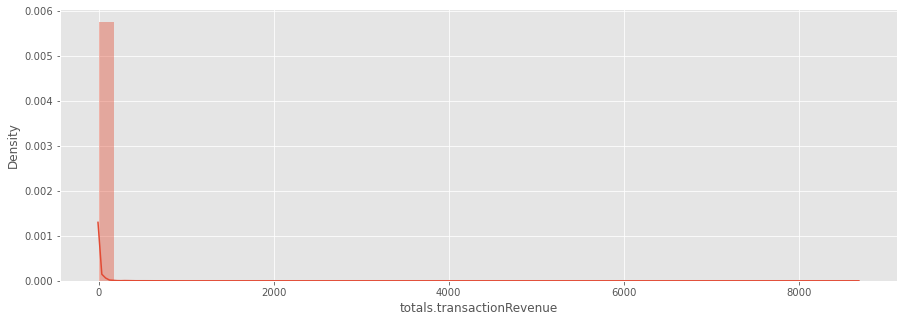

In [35]:
plt.figure(figsize=(15, 5))
sns.distplot(
    df[TARGET]
)

/Users/pedrocosta/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='totals.transactionRevenue'>

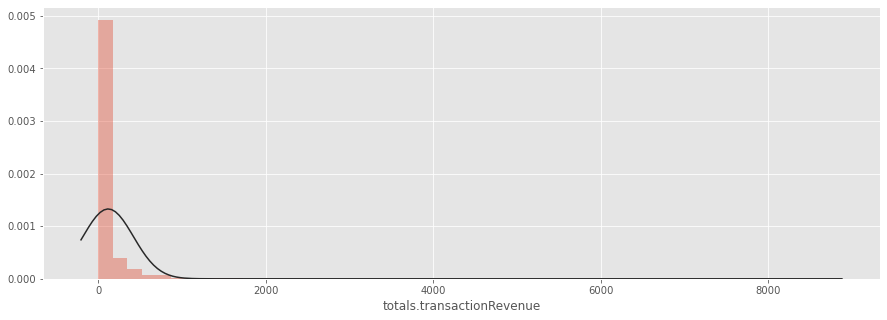

In [36]:
plt.figure(figsize=(15, 5))
sns.distplot(
    df[df['visitWithTransaction'] == 1][TARGET],
    fit = stats.norm,
    kde = False
)

The target distribution is skewed to the left. There are some transformations that will make some data normal. One example is the log-transformation. Let's try to apply a log-transformation to the target variable.

In [37]:
df['totals.transactionRevenueLN'] = df['totals.transactionRevenue'].apply(lambda x: np.log1p(x))

#Alternative: df['totals.transactionRevenueLN'] = np.log1p(df['totals.transactionRevenue'])

In [38]:
TARGET_LN = 'totals.transactionRevenueLN'

In [39]:
np.log(1)

0.0

/Users/pedrocosta/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='totals.transactionRevenueLN'>

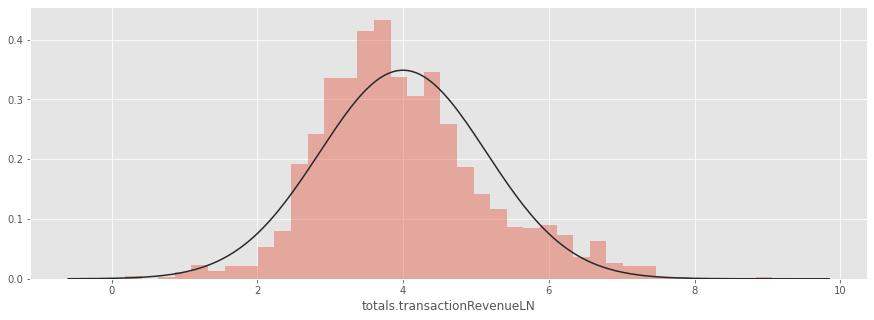

In [40]:
plt.figure(figsize=(15, 5))
sns.distplot(
    df[df['visitWithTransaction'] == 1][TARGET_LN],
    fit = stats.norm,
    kde=False
    
)

## MLC3: Data Preparation<a class="anchor" id="data_preparation"></a>


## MLC3.1: Data cleaning<a class="anchor" id="data_cleaning"></a>



### 3.1.4. Elimination of features with low variance<a class="anchor" id="low_variance"></a>



We could start with the univariate analysis of each variable, but we've seen that many of them are not going to be relevant for the model (0 variance). Let's identify columns with 0 variance first. We'll exclude those columns

In [41]:
# constant_columns = []
# for column in df.columns:
#        constant_columns.append(column)
#    if df[column].nunique() == 1:

In [42]:
constant_columns = [column for column in df.columns if df[column].nunique() == 1]

In [43]:
constant_columns

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'totals.bounces',
 'totals.newVisits']

In [44]:
df.drop(constant_columns, axis=1, inplace=True)

In [45]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 135547 entries, 0544964540242051041_1490971283 to 4632817159671077343_1481397815
Columns: 10 entries, date to totals.transactionRevenueLN
dtypes: float64(3), int64(4), object(3)
memory usage: 11.4+ MB


In [46]:
df.head(2).T

sessionId,0544964540242051041_1490971283,5317887555212111581_1500327373
date,20170331,20170717
visitNumber,2,1
device.browser,UC Browser,Chrome
device.operatingSystem,Android,Macintosh
geoNetwork.continent,Asia,Americas
totals.hits,2,1
totals.pageviews,2,1
totals.transactionRevenue,0,0
visitWithTransaction,0,0
totals.transactionRevenueLN,0,0


In [47]:
#df_description = df.describe(include='all').T

In [48]:
#df_description.to_excel('df_description.xlsx')

## MLC2.1: Univariate data analysis (part 2)


We had already started the univariate data analysis, but we had found very convenient to drop the identified variables without variance before analyzing the remaining variables in the dataset. That's ok! We don't need to follow the data preparation/transformation steps in a strict order. 


### 2.1.7-2.1.10. Variables distribution & relations with target<a class="anchor" id="variables_distribution"></a>



Let's start with **categorical variables** first

### 2.1.7-2.1.10. Variables distribution & relations with target - categorical<a class="anchor" id="variables_distribution_categorical"></a>




#### Categorical variables - Device - Device Browser

Let's take a look at the number of unique values for the device browser variable, and at their frequency distribution across the dataset

In [49]:
df['device.browser'].describe()

count     135547
unique        30
top       Chrome
freq       93125
Name: device.browser, dtype: object

In [50]:
df['device.browser'].value_counts(normalize=True) *100

Chrome                      68.703107
Safari                      20.083809
Firefox                      4.048780
Internet Explorer            2.126938
Edge                         1.183353
Android Webview              0.880138
Safari (in-app)              0.768737
Opera Mini                   0.672092
Opera                        0.641844
UC Browser                   0.294363
YaBrowser                    0.216161
Coc Coc                      0.084841
Amazon Silk                  0.066398
Android Browser              0.060496
Mozilla Compatible Agent     0.038363
MRCHROME                     0.035412
Maxthon                      0.031723
BlackBerry                   0.024346
Nintendo Browser             0.016968
Puffin                       0.006640
Nokia Browser                0.004427
Iron                         0.002951
LYF_LS_4002_12               0.002213
SeaMonkey                    0.001476
osee2unifiedRelease          0.000738
Lunascape                    0.000738
Seznam      

There are 30 unique values for the device.browser variable. But most of them are present in a very low fraction of visits. There are cases in which it might not make much sense to apply a one-hot-encoding to all possible values of the variable. Some browsers do not appear in our data very often. We could decide to keep only the top 5 browsers in our dataset, and we could aggregate the remaining one as part of an "other" category. 

We have identified the need to transform the device.browser data during the univariate analysis step. That's expected. Again, we don't need to wait until a data transformation stage to do so. No need to be too strict about the ordering within our ML Checklist. Let's apply that transformation right now! 



In [51]:
top_browsers = df['device.browser'].value_counts().head(5)

In [52]:
top_browsers

Chrome               93125
Safari               27223
Firefox               5488
Internet Explorer     2883
Edge                  1604
Name: device.browser, dtype: int64

In [53]:
top_browsers_list = top_browsers.index.to_list()

In [54]:
top_browsers_list

['Chrome', 'Safari', 'Firefox', 'Internet Explorer', 'Edge']

In [55]:
top_browsers_list.append('Others')

In [56]:
top_browsers_list

['Chrome', 'Safari', 'Firefox', 'Internet Explorer', 'Edge', 'Others']

In [57]:
df['device.browser'] = pd.Categorical(df['device.browser'], categories=top_browsers_list)

In [58]:
df['device.browser'].value_counts(dropna=False)

Chrome               93125
Safari               27223
Firefox               5488
NaN                   5224
Internet Explorer     2883
Edge                  1604
Others                   0
Name: device.browser, dtype: int64

In [59]:
df['device.browser'].fillna('Others', inplace=True)

Let's evaluate the variable distribution after the transformation

In [60]:
df['device.browser'].describe()

count     135547
unique         6
top       Chrome
freq       93125
Name: device.browser, dtype: object

In [61]:
df['device.browser'].value_counts(dropna=False)

Chrome               93125
Safari               27223
Firefox               5488
Others                5224
Internet Explorer     2883
Edge                  1604
Name: device.browser, dtype: int64

In [62]:
df['device.browser'].value_counts(normalize=True, dropna=False)

Chrome               0.687031
Safari               0.200838
Firefox              0.040488
Others               0.038540
Internet Explorer    0.021269
Edge                 0.011834
Name: device.browser, dtype: float64

In [63]:
df[df['visitWithTransaction'] == 1].pivot_table(index='device.browser', values=TARGET_LN, aggfunc=[len, np.mean])

,len,mean
,totals.transactionRevenueLN,totals.transactionRevenueLN
device.browser,,
Chrome,1495.0,4.039347
Safari,107.0,3.626049
Firefox,25.0,3.912903
Internet Explorer,18.0,3.419878
Edge,15.0,3.697995
Others,3.0,2.484490


We have not stored the output of the pivot command into any variable. Let's repeat the pivot transformation, but this time we'll store it as *_results_df*. We will rename the columns with more interpretable names

In [64]:
_results_df = df[df['visitWithTransaction'] == 1].pivot_table(index='device.browser', values=TARGET_LN, aggfunc=[len, np.mean])

In [65]:
_results_df.columns = ['transactions', 'mean_revenue_ln']

In [66]:
_results_df.head()

,transactions,mean_revenue_ln
device.browser,,
Chrome,1495.0,4.039347
Safari,107.0,3.626049
Firefox,25.0,3.912903
Internet Explorer,18.0,3.419878
Edge,15.0,3.697995


Let's include two additional columns into the *_results_df* table:
+ **n_rows**: number of registers per browser (sales and not sales)
+ **pct_rows**: pct of registers for each browser (sales and not sales)
+ **pct_transactions**: pct of registers with transaction for each browser with 

In [67]:
_results_df['n_rows'] = df['device.browser'].value_counts(dropna=False)

In [68]:
_results_df.head()

,transactions,mean_revenue_ln,n_rows
device.browser,,,
Chrome,1495.0,4.039347,93125
Safari,107.0,3.626049,27223
Firefox,25.0,3.912903,5488
Internet Explorer,18.0,3.419878,2883
Edge,15.0,3.697995,1604


In [69]:
_results_df['pct_rows'] = df['device.browser'].value_counts(normalize=True, dropna=False)

In [70]:
_results_df.head()

,transactions,mean_revenue_ln,n_rows,pct_rows
device.browser,,,,
Chrome,1495.0,4.039347,93125,0.687031
Safari,107.0,3.626049,27223,0.200838
Firefox,25.0,3.912903,5488,0.040488
Internet Explorer,18.0,3.419878,2883,0.021269
Edge,15.0,3.697995,1604,0.011834


In [71]:
_results_df['pct_transactions'] = _results_df['transactions'] / _results_df['n_rows']

In [72]:
_results_df.head()

,transactions,mean_revenue_ln,n_rows,pct_rows,pct_transactions
device.browser,,,,,
Chrome,1495.0,4.039347,93125,0.687031,0.016054
Safari,107.0,3.626049,27223,0.200838,0.003930
Firefox,25.0,3.912903,5488,0.040488,0.004555
Internet Explorer,18.0,3.419878,2883,0.021269,0.006243
Edge,15.0,3.697995,1604,0.011834,0.009352


In [73]:
_results_df = _results_df[['n_rows', 'pct_rows', 'transactions', 'pct_transactions', 'mean_revenue_ln']]

In [74]:
_results_df

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_ln
device.browser,,,,,
Chrome,93125,0.687031,1495.0,0.016054,4.039347
Safari,27223,0.200838,107.0,0.003930,3.626049
Firefox,5488,0.040488,25.0,0.004555,3.912903
Internet Explorer,2883,0.021269,18.0,0.006243,3.419878
Edge,1604,0.011834,15.0,0.009352,3.697995
Others,5224,0.038540,3.0,0.000574,2.484490


Let's plot the browsers distribution in the data (including all registers)

/Users/pedrocosta/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='device.browser', ylabel='count'>

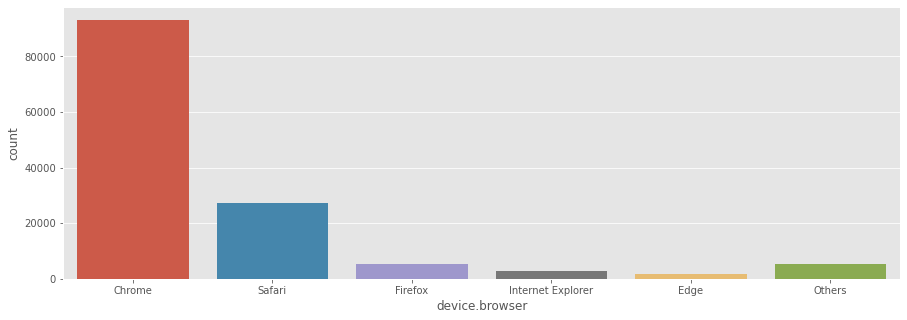

In [75]:
plt.figure(figsize=(15,5))
sns.countplot(
    df['device.browser']
)

And let's take a look at the target's distribution across browsers (the boxenplot includes an extended picture to the one offered by the classic bloxplots)

<AxesSubplot:xlabel='device.browser', ylabel='totals.transactionRevenueLN'>

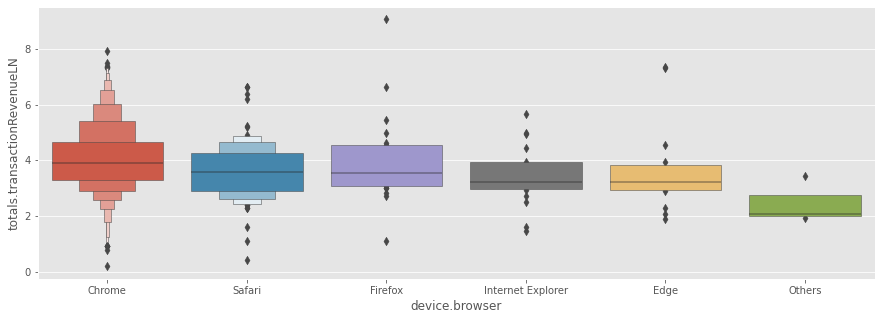

In [76]:
plt.figure(figsize=(15,5))
sns.boxenplot(
    data = df[df['visitWithTransaction'] == 1], 
    x = 'device.browser',
    y = TARGET_LN
)

We could have implemented a function to automate those plots. We'll do that now, and we'll use that function to plot the distribution of the remaining categorical variables in the data. 

In [77]:
def plot_cat_values(dataframe, column, target_column):
    plt.figure(figsize=(15,8))
    
    #en una única grafica de 2x1 en el primer slot
    ax1 = plt.subplot(2,1,1)
    ## Plot variable counts
    ax1 = sns.countplot(
        dataframe[column],
        order = list(dataframe[column].unique())
    )
    ax2 = plt.subplot(2,1,2) # share ax1 para que me pinte el axis en el mismo orden
    ## Plot variable counts, but only for registers with sale 
    ax2 = sns.boxenplot(
        data = dataframe[dataframe[target_column] > 0], 
        x = column,
        y = target_column,
        order = list(dataframe[column].unique())
    )
    plt.show()


/Users/pedrocosta/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


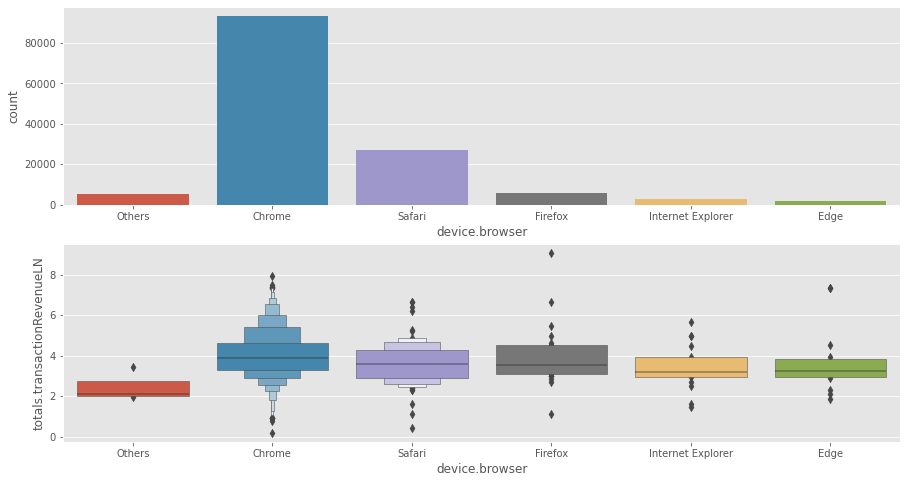

In [78]:
plot_cat_values(df, 'device.browser', TARGET_LN)

We are also implementing a second function to create the equivalent results table to the one we've created for the browsers variable (with n_rows, pct_rows, transactions, pct_transactions, and mean_revenue_ln)

In [79]:
def explore_cat_values(dataframe, column, target_column):
    _results_df = dataframe[dataframe[target_column] > 1].pivot_table(index=column, values=target_column, aggfunc=[len, np.mean])
    _results_df.columns = ['transactions', 'mean_revenue_ln']
    _results_df['n_rows'] = dataframe[column].value_counts(dropna=False)
    _results_df['pct_rows'] = dataframe[column].value_counts(normalize=True, dropna=False)
    _results_df['pct_transactions'] = _results_df['transactions'] / _results_df['n_rows']
    _results_df = _results_df[['n_rows', 'pct_rows', 'transactions', 'pct_transactions', 'mean_revenue_ln']]
    return _results_df

In [80]:
explore_cat_values(df, 'device.browser', TARGET_LN)

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_ln
device.browser,,,,,
Chrome,93125,0.687031,1489.0,0.015989,4.052518
Safari,27223,0.200838,106.0,0.003894,3.656495
Firefox,5488,0.040488,25.0,0.004555,3.912903
Internet Explorer,2883,0.021269,18.0,0.006243,3.419878
Edge,1604,0.011834,15.0,0.009352,3.697995
Others,5224,0.038540,3.0,0.000574,2.484490


And finally, we are also implementing a third function to aggregate the non-frequent values of a variable into an "other category". It will require three parameters: the dataframe, the variable, and the number of values to be kept outside the others category.  

In [81]:
def setOthers(dataframe, column, num_values):
    top_categories = dataframe[column].value_counts().head(num_values)
    top_categories_list = top_categories.index.to_list()
    top_categories_list.append('Others')
    dataframe[column] = pd.Categorical(dataframe[column], categories=top_categories_list)
    return dataframe[column].fillna('Others')

#### Categorical variables  - Device - Operating System

In [82]:
df['device.operatingSystem'].value_counts()

Windows          52746
Macintosh        38040
Android          18666
iOS              15954
Linux             5157
Chrome OS         3979
(not set)          690
Windows Phone      187
Samsung             47
BlackBerry          38
Nintendo Wii        16
Firefox OS          11
Xbox                 9
Nintendo WiiU        6
OpenBSD              1
Name: device.operatingSystem, dtype: int64

In [83]:
df['device.operatingSystem'].value_counts(normalize=True)

Windows          0.389134
Macintosh        0.280641
Android          0.137709
iOS              0.117701
Linux            0.038046
Chrome OS        0.029355
(not set)        0.005090
Windows Phone    0.001380
Samsung          0.000347
BlackBerry       0.000280
Nintendo Wii     0.000118
Firefox OS       0.000081
Xbox             0.000066
Nintendo WiiU    0.000044
OpenBSD          0.000007
Name: device.operatingSystem, dtype: float64

In [84]:
df['device.operatingSystem'] = setOthers(df, 'device.operatingSystem', 6)

In [85]:
df['device.operatingSystem'].value_counts()

Windows      52746
Macintosh    38040
Android      18666
iOS          15954
Linux         5157
Chrome OS     3979
Others        1005
Name: device.operatingSystem, dtype: int64

/Users/pedrocosta/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


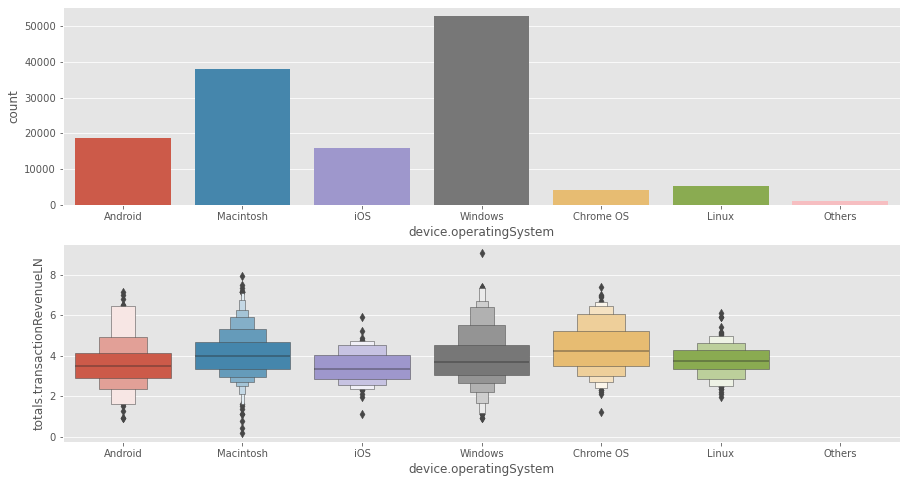

In [86]:
plot_cat_values(df, 'device.operatingSystem', TARGET_LN)

In [87]:
explore_cat_values(df, 'device.operatingSystem', TARGET_LN)

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_ln
device.operatingSystem,,,,,
Windows,52746,0.389134,331.0,0.006275,3.898382
Macintosh,38040,0.280641,909.0,0.023896,4.096559
Android,18666,0.137709,76.0,0.004072,3.724018
iOS,15954,0.117701,74.0,0.004638,3.437083
Linux,5157,0.038046,118.0,0.022882,3.782745
Chrome OS,3979,0.029355,148.0,0.037195,4.366367


#### Categorical variables -  GeoNetwork - Continent 

In [88]:
explore_cat_values(df, 'geoNetwork.continent', TARGET_LN)

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_ln
geoNetwork.continent,,,,,
Africa,2309,0.017035,1.0,0.000433,7.492983
Americas,67459,0.497680,1628.0,0.024133,4.005856
Asia,33539,0.247434,16.0,0.000477,4.411345
Europe,29735,0.219370,11.0,0.000370,4.043956


/Users/pedrocosta/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


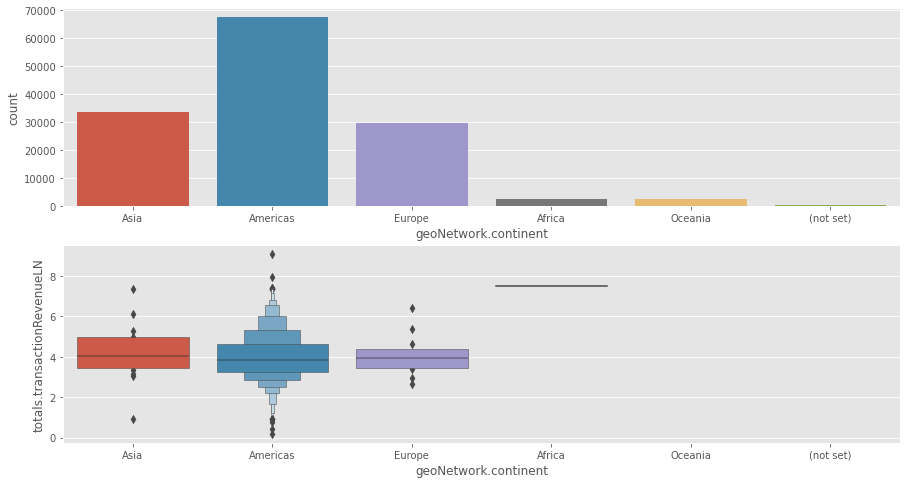

In [89]:
plot_cat_values(df, 'geoNetwork.continent', TARGET_LN)

### 2.1.7-2.1.10. Variables distribution & relations with target - numerical<a class="anchor" id="variables_distribution_numerical"></a>


#### Numerical variables  -  visitNumber


In [91]:
df['visitNumber'].head()

sessionId
0544964540242051041_1490971283    2
5317887555212111581_1500327373    1
2494424733344070750_1496401320    3
5122857189400199535_1495978490    1
6826136518561551939_1501081796    1
Name: visitNumber, dtype: int64

In [92]:
df['visitNumber'].describe()

count    135547.000000
mean          2.238508
std           8.915600
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         384.000000
Name: visitNumber, dtype: float64

<AxesSubplot:xlabel='visitNumber', ylabel='totals.transactionRevenueLN'>

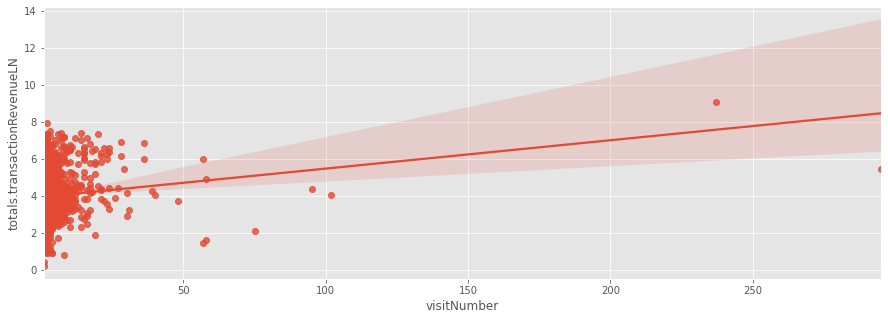

In [93]:
plt.figure(figsize=(15,5))
sns.regplot(
    data=df[df['visitWithTransaction'] == 1],
    x='visitNumber',
    y=TARGET_LN
)

In [94]:
df[['visitNumber', TARGET_LN]].head()

,visitNumber,totals.transactionRevenueLN
sessionId,,
0544964540242051041_1490971283,2,0.0
5317887555212111581_1500327373,1,0.0
2494424733344070750_1496401320,3,0.0
5122857189400199535_1495978490,1,0.0
6826136518561551939_1501081796,1,0.0


In [95]:
df[['visitNumber', TARGET_LN]].corr()

,visitNumber,totals.transactionRevenueLN
visitNumber,1.000000,0.027631
totals.transactionRevenueLN,0.027631,1.000000


In [96]:
df['visitNumberLN'] = df['visitNumber'].apply(lambda x: np.log1p(x))

<AxesSubplot:xlabel='visitNumberLN', ylabel='totals.transactionRevenueLN'>

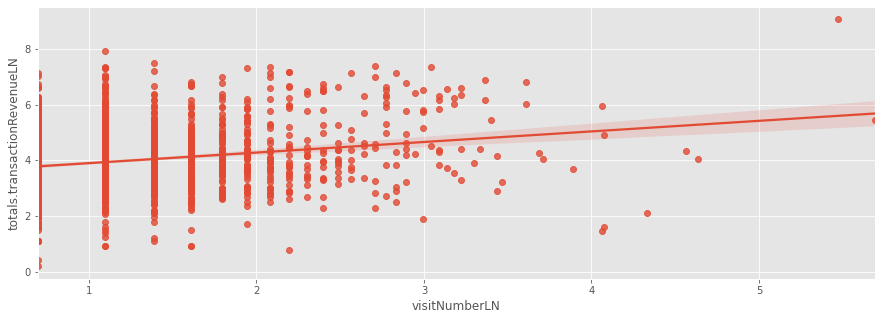

In [97]:
plt.figure(figsize=(15,5))
sns.regplot(
    data=df[df['visitWithTransaction'] == 1],
    x='visitNumberLN',
    y=TARGET_LN
)

In [98]:
df[['visitNumberLN', TARGET_LN]].corr()

,visitNumberLN,totals.transactionRevenueLN
visitNumberLN,1.000000,0.093194
totals.transactionRevenueLN,0.093194,1.000000


There is no significant correlation between them

#### Numerical variables -  Totals - Hits



In [99]:
df['totals.hits'].head(5)

sessionId
0544964540242051041_1490971283    2
5317887555212111581_1500327373    1
2494424733344070750_1496401320    5
5122857189400199535_1495978490    1
6826136518561551939_1501081796    2
Name: totals.hits, dtype: int64

In [100]:
df['totals.hits'].describe()

count    135547.000000
mean          4.564026
std           9.442314
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         500.000000
Name: totals.hits, dtype: float64

In [101]:
df['totals.hits'] = df['totals.hits'].astype(int)

In [102]:
df['totals.hits'].describe()

count    135547.000000
mean          4.564026
std           9.442314
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         500.000000
Name: totals.hits, dtype: float64

<AxesSubplot:xlabel='totals.hits', ylabel='totals.transactionRevenueLN'>

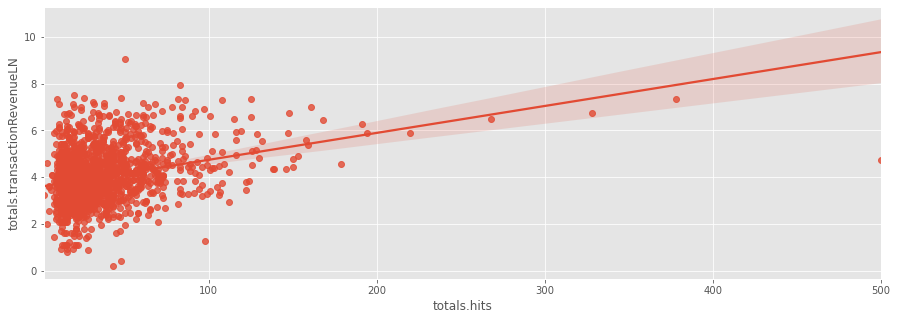

In [103]:
plt.figure(figsize=(15,5))
sns.regplot(
    data=df[df['visitWithTransaction'] == 1],
    x='totals.hits',
    y=TARGET_LN
)

In [104]:
df['totals.hitsLN'] = df['totals.hits'].apply(lambda x: np.log1p(x))

<AxesSubplot:xlabel='totals.hitsLN', ylabel='totals.transactionRevenueLN'>

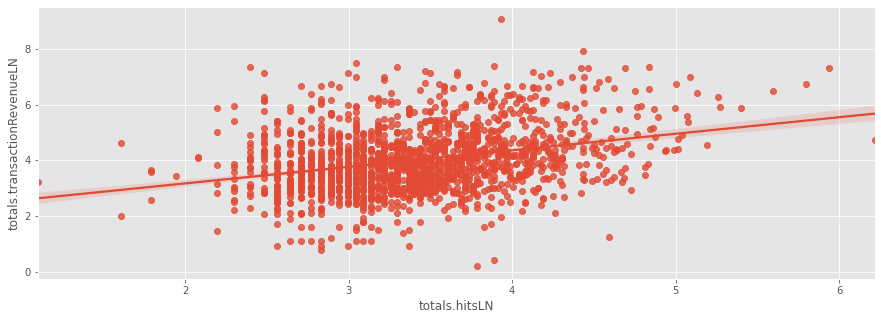

In [105]:
plt.figure(figsize=(15,5))
sns.regplot(
    data=df[df['visitWithTransaction'] == 1],
    x='totals.hitsLN',
    y=TARGET_LN
)

In [106]:
df[['totals.hitsLN', TARGET_LN]].corr()

,totals.hitsLN,totals.transactionRevenueLN
totals.hitsLN,1.000000,0.298749
totals.transactionRevenueLN,0.298749,1.000000


In [107]:
df.pivot_table(index='totals.hits', values='visitWithTransaction', aggfunc=[len, np.sum, np.mean]).head(30)

,len,sum,mean
,visitWithTransaction,visitWithTransaction,visitWithTransaction
totals.hits,,,
1,67102,0,0.000000
2,20769,1,0.000048
3,10494,0,0.000000
4,6347,2,0.000315
5,4749,3,0.000632
6,3440,1,0.000291
7,2965,2,0.000675
8,2288,6,0.002622


#### Numerical variables -  Totals - PageViews

In [108]:
df['totals.pageviews'].head(5)

sessionId
0544964540242051041_1490971283    2.0
5317887555212111581_1500327373    1.0
2494424733344070750_1496401320    3.0
5122857189400199535_1495978490    1.0
6826136518561551939_1501081796    2.0
Name: totals.pageviews, dtype: float64

In [109]:
#df['totals.pageviews'] = df['totals.pageviews'].astype(int)

## There were some nulls, I need to deal with them first!!

In [110]:
df['totals.pageviews'].fillna(0, inplace=True)

In [111]:
df['totals.pageviews'] = df['totals.pageviews'].astype(int)

In [112]:
df['totals.pageviews'].describe()

count    135547.000000
mean          3.828620
std           6.890973
min           0.000000
25%           1.000000
50%           1.000000
75%           4.000000
max         351.000000
Name: totals.pageviews, dtype: float64

<AxesSubplot:xlabel='totals.pageviews', ylabel='totals.transactionRevenueLN'>

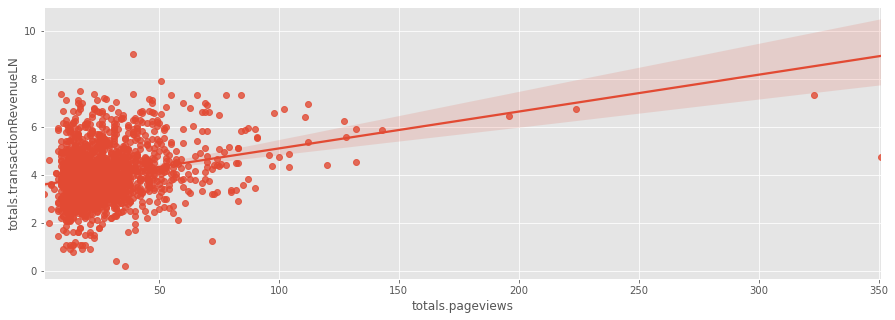

In [113]:
plt.figure(figsize=(15,5))
sns.regplot(
    data=df[df['visitWithTransaction'] == 1],
    x='totals.pageviews',
    y=TARGET_LN
)

In [114]:
df['totals.pageviewsLN'] = df['totals.pageviews'].apply(lambda x: np.log1p(x))

<AxesSubplot:xlabel='totals.pageviewsLN', ylabel='totals.transactionRevenueLN'>

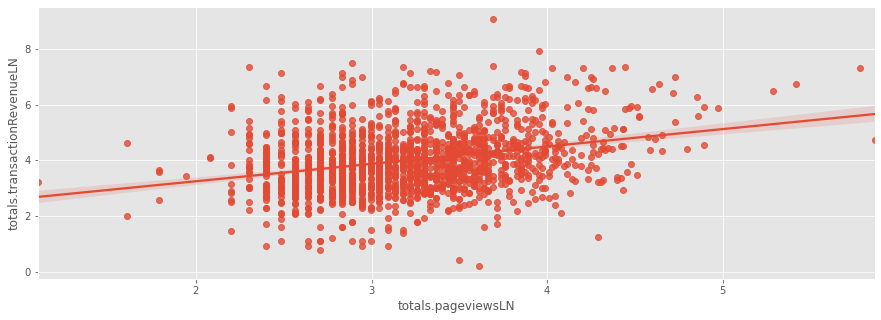

In [115]:
plt.figure(figsize=(15,5))
sns.regplot(
    data=df[df['visitWithTransaction'] == 1],
    x='totals.pageviewsLN',
    y=TARGET_LN
)

We can evaluate the relation between PV and Hits 

In [116]:
df[['totals.pageviews', 'totals.hits']].corr()

,totals.pageviews,totals.hits
totals.pageviews,1.000000,0.983442
totals.hits,0.983442,1.000000


They are very correlated. Depending on the algorithm that we are planning to use, me might need to exclude one. For trees, we are ok

Let's drop the non-transformed columns. We'll use the log-transformed variables that we have created

In [117]:
df.drop(['totals.pageviews','totals.hits','visitNumber'],axis=1, inplace=True)


## MLC3.2: Data transformation<a class="anchor" id="data_transformation"></a>



Keep a copy of the original dataframe (alternatively, you could work on a copy of the dataframe)

In [118]:
df_copy = df.copy()

### 3.2.1. Transformation of categorical variables<a class="anchor" id="transformation_categorical"></a>

In [119]:
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
date,135547.0,2.016588e+07,4697.786746,2.016080e+07,2.016103e+07,2.017011e+07,2.017042e+07,2.017080e+07
totals.transactionRevenue,135547.0,1.476306e+00,35.818411,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.677830e+03
visitWithTransaction,135547.0,1.226881e-02,0.110083,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
totals.transactionRevenueLN,135547.0,4.905394e-02,0.458016,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.068642e+00
visitNumberLN,135547.0,8.843680e-01,0.485903,6.931472e-01,6.931472e-01,6.931472e-01,6.931472e-01,5.953243e+00
totals.hitsLN,135547.0,1.263731e+00,0.782952,6.931472e-01,6.931472e-01,1.098612e+00,1.609438e+00,6.216606e+00
totals.pageviewsLN,135547.0,1.214255e+00,0.710661,0.000000e+00,6.931472e-01,6.931472e-01,1.609438e+00,5.863631e+00


In [120]:
df.describe(exclude=np.number).T

,count,unique,top,freq
device.browser,135547,6,Chrome,93125
device.operatingSystem,135547,7,Windows,52746
geoNetwork.continent,135547,6,Americas,67459


In [121]:
def generate_dummies(dataframe, column_name):
    _dummy_dataset = pd.get_dummies(dataframe[column_name], prefix=column_name)
    dataframe = pd.concat([dataframe, _dummy_dataset], axis=1)
    return dataframe.drop(column_name, axis=1)

In [122]:
for column in df.select_dtypes(exclude=np.number).columns:
    df = generate_dummies(df, column)

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135547 entries, 0544964540242051041_1490971283 to 4632817159671077343_1481397815
Data columns (total 26 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   date                              135547 non-null  int64  
 1   totals.transactionRevenue         135547 non-null  float64
 2   visitWithTransaction              135547 non-null  int64  
 3   totals.transactionRevenueLN       135547 non-null  float64
 4   visitNumberLN                     135547 non-null  float64
 5   totals.hitsLN                     135547 non-null  float64
 6   totals.pageviewsLN                135547 non-null  float64
 7   device.browser_Chrome             135547 non-null  uint8  
 8   device.browser_Safari             135547 non-null  uint8  
 9   device.browser_Firefox            135547 non-null  uint8  
 10  device.browser_Internet Explorer  135547 non-null  uint8  
 11  devi

In [124]:
df.describe(include=np.number).T.head(20)

,count,mean,std,min,25%,50%,75%,max
date,135547.0,2.016588e+07,4697.786746,2.016080e+07,2.016103e+07,2.017011e+07,2.017042e+07,2.017080e+07
totals.transactionRevenue,135547.0,1.476306e+00,35.818411,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.677830e+03
visitWithTransaction,135547.0,1.226881e-02,0.110083,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
totals.transactionRevenueLN,135547.0,4.905394e-02,0.458016,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.068642e+00
visitNumberLN,135547.0,8.843680e-01,0.485903,6.931472e-01,6.931472e-01,6.931472e-01,6.931472e-01,5.953243e+00
totals.hitsLN,135547.0,1.263731e+00,0.782952,6.931472e-01,6.931472e-01,1.098612e+00,1.609438e+00,6.216606e+00
totals.pageviewsLN,135547.0,1.214255e+00,0.710661,0.000000e+00,6.931472e-01,6.931472e-01,1.609438e+00,5.863631e+00
device.browser_Chrome,135547.0,6.870311e-01,0.463704,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
device.browser_Safari,135547.0,2.008381e-01,0.400629,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
device.browser_Firefox,135547.0,4.048780e-02,0.197101,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [125]:
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
date,135547.0,2.016588e+07,4697.786746,2.016080e+07,2.016103e+07,2.017011e+07,2.017042e+07,2.017080e+07
totals.transactionRevenue,135547.0,1.476306e+00,35.818411,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.677830e+03
visitWithTransaction,135547.0,1.226881e-02,0.110083,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
totals.transactionRevenueLN,135547.0,4.905394e-02,0.458016,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.068642e+00
visitNumberLN,135547.0,8.843680e-01,0.485903,6.931472e-01,6.931472e-01,6.931472e-01,6.931472e-01,5.953243e+00
totals.hitsLN,135547.0,1.263731e+00,0.782952,6.931472e-01,6.931472e-01,1.098612e+00,1.609438e+00,6.216606e+00
totals.pageviewsLN,135547.0,1.214255e+00,0.710661,0.000000e+00,6.931472e-01,6.931472e-01,1.609438e+00,5.863631e+00
device.browser_Chrome,135547.0,6.870311e-01,0.463704,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
device.browser_Safari,135547.0,2.008381e-01,0.400629,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
device.browser_Firefox,135547.0,4.048780e-02,0.197101,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


### 3.2.2. Transformation of date variables <a class="anchor" id="data_transformation_date"></a>
#### 3.2.2. Transformation of date variables - date

We are transforming our date variable into a date format, and we'll include a few additional time-based variables to our dataframe (might be very helpful for the model): year, month, monthday, quarter, week, weekday.  




In [126]:
df['date'].describe()

count    1.355470e+05
mean     2.016588e+07
std      4.697787e+03
min      2.016080e+07
25%      2.016103e+07
50%      2.017011e+07
75%      2.017042e+07
max      2.017080e+07
Name: date, dtype: float64

In [127]:
df['date'].head()

sessionId
0544964540242051041_1490971283    20170331
5317887555212111581_1500327373    20170717
2494424733344070750_1496401320    20170602
5122857189400199535_1495978490    20170528
6826136518561551939_1501081796    20170726
Name: date, dtype: int64

In [128]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

In [129]:
df['date'].head()

sessionId
0544964540242051041_1490971283   2017-03-31
5317887555212111581_1500327373   2017-07-17
2494424733344070750_1496401320   2017-06-02
5122857189400199535_1495978490   2017-05-28
6826136518561551939_1501081796   2017-07-26
Name: date, dtype: datetime64[ns]

In [130]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['monthDay'] = df['date'].dt.day
df['weekDay'] = df['date'].dt.weekday
df['quarter'] = df['date'].dt.quarter
df['week'] = df['date'].dt.week

<ipython-input-130-54da18f9a277>:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week'] = df['date'].dt.week


In [131]:
df.head(5).T

sessionId,0544964540242051041_1490971283,5317887555212111581_1500327373,2494424733344070750_1496401320,5122857189400199535_1495978490,6826136518561551939_1501081796
date,2017-03-31 00:00:00,2017-07-17 00:00:00,2017-06-02 00:00:00,2017-05-28 00:00:00,2017-07-26 00:00:00
totals.transactionRevenue,0,0,0,0,0
visitWithTransaction,0,0,0,0,0
totals.transactionRevenueLN,0,0,0,0,0
visitNumberLN,1.09861,0.693147,1.38629,0.693147,0.693147
totals.hitsLN,1.09861,0.693147,1.79176,0.693147,1.09861
totals.pageviewsLN,1.09861,0.693147,1.38629,0.693147,1.09861
device.browser_Chrome,0,1,1,1,1
device.browser_Safari,0,0,0,0,0
device.browser_Firefox,0,0,0,0,0


We are excluding the original date variable

In [132]:
df.drop('date', axis=1, inplace=True)

Finally, we need to exclude the variables that are equivalent to the output we are aiming to predict, or those that won't be available for predictions in the future

In [133]:
target_linked_features = ['totals.transactionRevenue', 'visitWithTransaction']

In [134]:
df.drop(target_linked_features, axis=1, inplace=True)

## MLC4. Modelling<a class="anchor" id="modelling"></a>

### MLC4.1. Dataset partition and sampling<a class="anchor" id="dataset_partition"></a>

### a) Train/test split  


First, we need to evaluate the target distribution across time. Does it vary significantly from month to month? If it does, how should we select the validation period? We won't be using our model for a particular time of the year (e.g. Black Friday Campaign). If we were, we would need to take that period for evaluation (if available). 

Our model probably needs to work ok throughout the year. 

In [135]:
df.pivot_table(index=['year', 'month'], values=TARGET_LN, aggfunc=len)

totals.transactionRevenueLN
year month                             
2016 8                          11296.0
     9                          10714.0
     10                         14701.0
     11                         16952.0
     12                         11917.0
2017 1                           9730.0
     2                           9434.0
     3                          10551.0
     4                          10043.0
     5                           9594.0
     6                           9365.0
     7                          10855.0
     8                            395.0

We could take a random sample. But what happens if the behavior has changed significantly with the years? It's a good practice to take the most recent period (the closes to the period we'll be predicting, the future). 

Let's put aside the last 3 months for validation. Careful, it's possible that we end up seeing that our model does not work for the winter months (we are taking summer months). That's something we'll have to be careful about. 

This is a quick way to take the 3 last months (without transformation needed)

In [136]:
df_val = df[df['year'] * 100 + df['month'] >= 201706]
df_dev = df[df['year'] * 100 + df['month'] < 201706]

In [137]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20615 entries, 5317887555212111581_1500327373 to 4555778872075782207_1496599367
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   totals.transactionRevenueLN       20615 non-null  float64
 1   visitNumberLN                     20615 non-null  float64
 2   totals.hitsLN                     20615 non-null  float64
 3   totals.pageviewsLN                20615 non-null  float64
 4   device.browser_Chrome             20615 non-null  uint8  
 5   device.browser_Safari             20615 non-null  uint8  
 6   device.browser_Firefox            20615 non-null  uint8  
 7   device.browser_Internet Explorer  20615 non-null  uint8  
 8   device.browser_Edge               20615 non-null  uint8  
 9   device.browser_Others             20615 non-null  uint8  
 10  device.operatingSystem_Windows    20615 non-null  uint8  
 11  device.operatingSy

In [138]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114932 entries, 0544964540242051041_1490971283 to 4632817159671077343_1481397815
Data columns (total 29 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   totals.transactionRevenueLN       114932 non-null  float64
 1   visitNumberLN                     114932 non-null  float64
 2   totals.hitsLN                     114932 non-null  float64
 3   totals.pageviewsLN                114932 non-null  float64
 4   device.browser_Chrome             114932 non-null  uint8  
 5   device.browser_Safari             114932 non-null  uint8  
 6   device.browser_Firefox            114932 non-null  uint8  
 7   device.browser_Internet Explorer  114932 non-null  uint8  
 8   device.browser_Edge               114932 non-null  uint8  
 9   device.browser_Others             114932 non-null  uint8  
 10  device.operatingSystem_Windows    114932 non-null  uint8  
 11  devi

In [139]:
df_val_X = df_val.drop(TARGET_LN, axis=1)
df_val_y = df_val[[TARGET_LN]]
df_dev_X = df_dev.drop(TARGET_LN, axis=1)
df_dev_y = df_dev[[TARGET_LN]]

In [140]:
df_val_X.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 20615 entries, 5317887555212111581_1500327373 to 4555778872075782207_1496599367
Columns: 28 entries, visitNumberLN to week
dtypes: float64(3), int64(6), uint8(19)
memory usage: 1.9+ MB


In [141]:
df_val_y.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 20615 entries, 5317887555212111581_1500327373 to 4555778872075782207_1496599367
Columns: 1 entries, totals.transactionRevenueLN to totals.transactionRevenueLN
dtypes: float64(1)
memory usage: 322.1+ KB


In [142]:
df_dev_X.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 114932 entries, 0544964540242051041_1490971283 to 4632817159671077343_1481397815
Columns: 28 entries, visitNumberLN to week
dtypes: float64(3), int64(6), uint8(19)
memory usage: 10.9+ MB


In [143]:
df_dev_y.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 114932 entries, 0544964540242051041_1490971283 to 4632817159671077343_1481397815
Columns: 1 entries, totals.transactionRevenueLN to totals.transactionRevenueLN
dtypes: float64(1)
memory usage: 1.8+ MB


### b) Determine validation strategy (Random Holdout) & partition policy for test set (random)

In [144]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    df_dev_X,
    df_dev_y,
    random_state = RANDOM_STATE,
    test_size = 0.3
)

In [145]:
X_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 80452 entries, 3389168322304694026_1485434699 to 3413232331832441059_1481540934
Columns: 28 entries, visitNumberLN to week
dtypes: float64(3), int64(6), uint8(19)
memory usage: 7.6+ MB


In [146]:
X_test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 34480 entries, 3809714131891697659_1470385143 to 239777896625039218_1472033885
Columns: 28 entries, visitNumberLN to week
dtypes: float64(3), int64(6), uint8(19)
memory usage: 3.3+ MB


In [147]:
y_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 80452 entries, 3389168322304694026_1485434699 to 3413232331832441059_1481540934
Columns: 1 entries, totals.transactionRevenueLN to totals.transactionRevenueLN
dtypes: float64(1)
memory usage: 1.2+ MB


In [148]:
y_test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 34480 entries, 3809714131891697659_1470385143 to 239777896625039218_1472033885
Columns: 1 entries, totals.transactionRevenueLN to totals.transactionRevenueLN
dtypes: float64(1)
memory usage: 538.8+ KB


### MLC4.2. Model definition<a class="anchor" id="model_definition"></a>


### MLC4.2.a Linear Regression model<a class="anchor" id="linear_regression"></a>

We are instantiating a linear regressor model

In [149]:
reg_model = linear_model.LinearRegression()

In [150]:
%%time
reg_model.fit(X_train, y_train)


CPU times: user 75.8 ms, sys: 35.9 ms, total: 112 ms
Wall time: 53.3 ms


LinearRegression()

In [151]:
# The coefficients
print("Coefficients: \n", reg_model.coef_)


Coefficients: 
 [[ 4.97699527e-02 -1.78340557e-01  3.79293516e-01  1.03337329e+10
   1.03337329e+10  1.03337329e+10  1.03337329e+10  1.03337329e+10
   1.03337329e+10 -3.67668550e+10 -3.67668550e+10 -3.67668550e+10
  -3.67668550e+10 -3.67668550e+10 -3.67668550e+10 -3.67668550e+10
  -8.90130929e+09 -8.90130929e+09 -8.90130929e+09 -8.90130929e+09
  -8.90130929e+09 -8.90130929e+09  3.78642235e-02 -6.71705696e-03
  -5.41218909e-04 -3.99706632e-04  1.27997359e-02  1.65335444e-03]]


### MLC5.a Model evaluation (linear regresssion) <a class="anchor" id="model_evaluation"></a>

#### a) Get predictions for the train set

In [152]:
train_predictions = reg_model.predict(X_train)


In [153]:
train_predictions

array([[-0.0361557 ],
       [ 0.04170227],
       [-0.04069519],
       ...,
       [-0.0837326 ],
       [ 0.2141037 ],
       [-0.06491852]])

In [154]:
train_predictions = pd.DataFrame(reg_model.predict(X_train), columns=['Prediction'], index=X_train.index)


In [155]:
train_predictions.head()

,Prediction
sessionId,
3389168322304694026_1485434699,-0.036156
2168037235478908257_1485336518,0.041702
1672966426026861277_1478096762,-0.040695
3160149925982139631_1490990967,-0.069046
5086041801666974799_1481477566,0.230598


In [156]:
results_df_train = y_train.join(train_predictions)


Since our dataset has a very high fraction of 0s (unbalanced dataset), I expect the avg. revenue to be very low. Let's take a look at predictions for the sessions with highest transaction revenue 

In [157]:
results_df_train.sort_values(by='totals.transactionRevenueLN', ascending=False).head()

,totals.transactionRevenueLN,Prediction
sessionId,,
1957458976293878100_1490380560,9.068642,0.728836
0291002892578472269_1493996088,7.927364,0.581085
4984366501121503466_1483653271,7.399043,0.653366
442570016186963075_1471985768,7.369815,0.476089
1956307607572137989_1479742819,7.361534,0.367821


In [158]:
results_df_train[results_df_train["totals.transactionRevenueLN"]>0].describe()

,totals.transactionRevenueLN,Prediction
count,943.000000,943.000000
mean,4.015934,0.470035
std,1.156528,0.106702
min,0.182322,0.185356
25%,3.257712,0.391010
50%,3.857989,0.463898
75%,4.639078,0.536629
max,9.068642,0.934792


As expected, our mean predictions for sessions with transaction are not higher than 0.5 (remember that we are still working in log-scales). The observed mean in our data is around 4. Even our predicted maximum is lower than 1. The linear regression is struggling with the imbalanced dataset of our problem. 

Let's rename the columns for simplicity, and let's calculate the evaluation metrics (mae, mse, rmse) manually (without using the functions available in the metrics library). 

In [159]:
results_df_train.columns = ['Target', 'Prediction']


In [160]:
results_df_train['error'] = results_df_train['Target'] - results_df_train['Prediction']
results_df_train['squared_error'] = results_df_train['error'] ** 2


In [161]:
mse_train = results_df_train['squared_error'].mean()
rmse_train = np.sqrt(results_df_train['squared_error'].mean())
mae_train = np.abs(results_df_train['error']).mean()


In [162]:
print('TRAIN: MSE: {} - RMSE: {} - MAE: {}'.format(mse_train, rmse_train, mae_train))


TRAIN: MSE: 0.18201142565244477 - RMSE: 0.426627971015081 - MAE: 0.14100863750035303


#### b) Get predictions for the test set

Let's repeat the same procedure for the test set. Our performance in the train dataset is already quite bad. Are we also overfitting the training data? 

In [163]:
test_predictions = pd.DataFrame(reg_model.predict(X_test), columns=['Prediction'], index=X_test.index)


In [164]:
results_df_test = y_test.join(test_predictions)

In [165]:
results_df_test.columns = ['Target', 'Prediction']

Let's calculate the r2 score of the model (coefficient of determination), which indicates the proportion of the variation in the dependent variable that is predictable from the independent variable(s)

In [166]:
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(results_df_test.Target, results_df_test.Prediction))

Coefficient of determination: 0.10


In [167]:
results_df_test['error'] = results_df_test['Target'] - results_df_test['Prediction']
results_df_test['squared_error'] = results_df_test['error'] ** 2


In [168]:
mse = results_df_test['squared_error'].mean()
rmse = np.sqrt(results_df_test['squared_error'].mean())
mae = np.abs(results_df_test['squared_error']).mean()

In [169]:
print('TRAIN: MSE: {} - RMSE: {} - MAE: {}'.format(mse_train, rmse_train, mae_train))
print('TEST: MSE: {} - RMSE: {} - MAE: {}'.format(mse, rmse, mae))

TRAIN: MSE: 0.18201142565244477 - RMSE: 0.426627971015081 - MAE: 0.14100863750035303
TEST: MSE: 0.18815613984983987 - RMSE: 0.43376968525917053 - MAE: 0.18815613984983987


Our evaluation metrics might give a very optimistic impression. But remember that due to the imbalanced nature of the dataset, if the model predicted always 0, it will be doing it right for most of the sample.  

Let's recalculate those metrics for registers with target > 0

In [170]:
mse_train = results_df_train[results_df_train.Target>0]['squared_error'].mean()
rmse_train = np.sqrt(results_df_train[results_df_train.Target>0]['squared_error'].mean())
mae_train = np.abs(results_df_train[results_df_train.Target>0]['error']).mean()


mse = results_df_test[results_df_test.Target>0]['squared_error'].mean()
rmse = np.sqrt(results_df_test[results_df_test.Target>0]['squared_error'].mean())
mae = np.abs(results_df_test[results_df_test.Target>0]['squared_error']).mean()

In [171]:
print('TRAIN: MSE: {} - RMSE: {} - MAE: {}'.format(mse_train, rmse_train, mae_train))
print('TEST: MSE: {} - RMSE: {} - MAE: {}'.format(mse, rmse, mae))

TRAIN: MSE: 13.828764511538976 - RMSE: 3.718704681947597 - MAE: 3.5467035289599966
TEST: MSE: 13.830046067332457 - RMSE: 3.7188769900781145 - MAE: 13.830046067332457


Those metrics are showing a very different picture now! 

Another way to observe the extent to which we are under-predicting sales is to plot real vs predicted sales with a simple scatter plot. 

<AxesSubplot:xlabel='Target', ylabel='Prediction'>

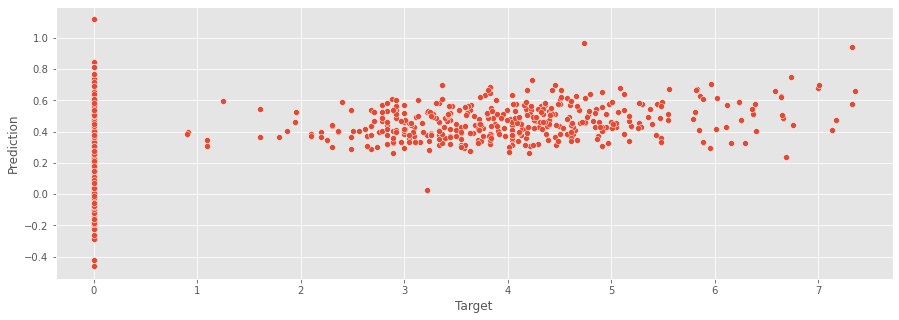

In [172]:
plt.figure(figsize=(15,5))
sns.scatterplot(
    data = results_df_test,
    x= 'Target',
    y =  'Prediction'
)

### MLC4.2.b Gradient Boosting model<a class="anchor" id="xgboost"></a>

We are instantiating a xgboost regressor with 200 trees and a max_depth = 6

In [173]:
first_model = xgb.XGBRegressor(random_state=42, n_estimators=200, max_depth=6, min_sample_split = 20, learning_rate = 0.02, colsample_bytree = 0.6)

In [174]:
%%time
first_model.fit(X_train, y_train)

[19:01:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { min_sample_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


CPU times: user 23 s, sys: 7.6 s, total: 30.6 s
Wall time: 5.31 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=6,
             min_child_weight=1, min_sample_split=20, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=8,
             num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

Text(0.5, 0, 'XGBRegressor Feature Importance')

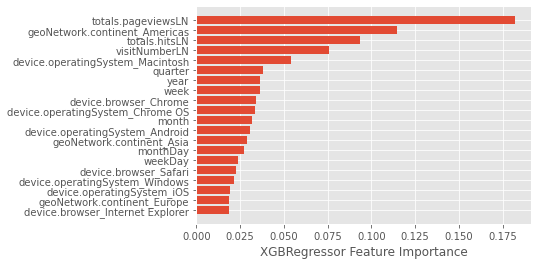

In [175]:
sorted_idx = first_model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx][-20:], first_model.feature_importances_[sorted_idx][-20:])
plt.xlabel("XGBRegressor Feature Importance")


### MLC5.b. Model evaluation (xgboost) 

#### a) Get predictions for train and test sets

In [176]:
train_predictions = pd.DataFrame(first_model.predict(X_train), columns=['Prediction'], index=X_train.index)
test_predictions = pd.DataFrame(first_model.predict(X_test), columns=['Prediction'], index=X_test.index)

In [177]:
results_df_train = y_train.join(train_predictions)
results_df_test = y_test.join(test_predictions)

Since our dataset has a very high fraction of 0s (unbalanced dataset), I expect the avg. revenue to be very low. Let's take a look at predictions for the sessions with highest transaction revenue 

In [178]:
results_df_test.sort_values(by='totals.transactionRevenueLN', ascending=False).head()

,totals.transactionRevenueLN,Prediction
sessionId,,
6499749315992064304_1481723414,7.349347,2.351944
3704081881488905199_1494031524,7.328116,0.200919
9264804092676520813_1472130683,7.327472,1.248147
7756103894574714837_1480563847,7.167038,1.040703
7990135994432965391_1481303384,7.129217,0.572850


In [179]:
results_df_test[results_df_test["totals.transactionRevenueLN"]>0].Prediction.describe()

count    419.000000
mean       1.111560
std        0.705051
min        0.010826
25%        0.584430
50%        0.958863
75%        1.508565
max        3.618445
Name: Prediction, dtype: float64

In [180]:
results_df_train.columns = ['Target', 'Prediction']
results_df_test.columns = ['Target', 'Prediction']

In [181]:
results_df_train.describe()

,Target,Prediction
count,80462.000000,80462.000000
mean,0.047066,0.054915
std,0.449956,0.229648
min,0.000000,-0.329685
25%,0.000000,0.006687
50%,0.000000,0.007987
75%,0.000000,0.012960
max,9.068642,4.531991


In [182]:
results_df_train[results_df_train.Target>0].describe()

,Target,Prediction
count,943.000000,943.000000
mean,4.015934,1.415429
std,1.156528,0.866455
min,0.182322,0.013900
25%,3.257712,0.719132
50%,3.857989,1.284402
75%,4.639078,2.023781
max,9.068642,4.531991


In [183]:
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(results_df_test.Target, results_df_test.Prediction))

Coefficient of determination: 0.28


In [184]:
mse_train = mean_squared_error(results_df_train.Target, results_df_train.Prediction)
rmse_train = np.sqrt(mse_train)
mae_train =  mean_absolute_error(results_df_train.Target, results_df_train.Prediction)

mse = mean_squared_error(results_df_test.Target, results_df_test.Prediction)
rmse = np.sqrt(mse)
mae =  mean_absolute_error(results_df_test.Target, results_df_test.Prediction)

In [185]:
print('TRAIN: MSE: {} - RMSE: {} - MAE: {}'.format(mse_train, rmse_train, mae_train))
print('TEST: MSE: {} - RMSE: {} - MAE: {}'.format(mse, rmse, mae))

TRAIN: MSE: 0.11622641791611467 - RMSE: 0.34091995822496907 - MAE: 0.06926170493547498
TEST: MSE: 0.15150382819045347 - RMSE: 0.38923492673506765 - MAE: 0.07847150466815185


In [186]:
mse_train = mean_squared_error(results_df_train[results_df_train.Target>0].Target, results_df_train[results_df_train.Target>0].Prediction)
rmse_train = np.sqrt(mse_train)
mae_train =  mean_absolute_error(results_df_train[results_df_train.Target>0].Target, results_df_train[results_df_train.Target>0].Prediction)

mse = mean_squared_error(results_df_test[results_df_test.Target>0].Target, results_df_test[results_df_test.Target>0].Prediction)
rmse = np.sqrt(mse)
mae =  mean_absolute_error(results_df_test[results_df_test.Target>0].Target, results_df_test[results_df_test.Target>0].Prediction)

In [187]:
print('TRAIN: MSE: {} - RMSE: {} - MAE: {}'.format(mse_train, rmse_train, mae_train))
print('TEST: MSE: {} - RMSE: {} - MAE: {}'.format(mse, rmse, mae))

TRAIN: MSE: 7.913216199466282 - RMSE: 2.813043938417294 - MAE: 2.6067942771554296
TEST: MSE: 9.882325504149362 - RMSE: 3.1436166280495086 - MAE: 2.9087446204367464


<AxesSubplot:xlabel='Target', ylabel='Prediction'>

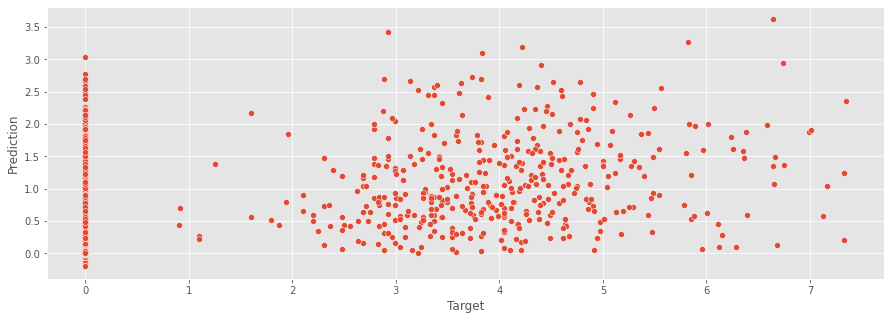

In [188]:
plt.figure(figsize=(15,5))
sns.scatterplot(
    data = results_df_test,
    x= 'Target',
    y =  'Prediction'
)

### MLC4.2.c Gradient Boosting model with undersampling<a class="anchor" id="xgboost_under"></a>


We are using an undersampling approach. We'll rebalance the data to achieve a 5-95% distribution (not too aggressive). 

Let's split 0 and non-0 registers into two independent dataframes

In [189]:
df_dev_zero = df_dev[df_dev[TARGET_LN] == 0]

In [190]:
df_dev_nonzero = df_dev[df_dev[TARGET_LN] > 0]

In [191]:
df_dev_zero.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 113571 entries, 0544964540242051041_1490971283 to 4632817159671077343_1481397815
Columns: 29 entries, totals.transactionRevenueLN to week
dtypes: float64(4), int64(6), uint8(19)
memory usage: 11.6+ MB


In [192]:
df_dev_nonzero.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 1361 entries, 6298030765010140996_1491546666 to 824955529524013757_1479756432
Columns: 29 entries, totals.transactionRevenueLN to week
dtypes: float64(4), int64(6), uint8(19)
memory usage: 142.2+ KB


In [193]:
n_zeros = len(df_dev_nonzero) * 19

In [194]:
1/(19+1)

0.05

In [195]:
n_zeros

25859

In [196]:
df_dev_zero_sample = df_dev_zero.sample(n = n_zeros, random_state = RANDOM_STATE)

In [197]:
df_dev_zero_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25859 entries, 2081430020047118970_1471091356 to 3359769322633661312_1473717120
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   totals.transactionRevenueLN       25859 non-null  float64
 1   visitNumberLN                     25859 non-null  float64
 2   totals.hitsLN                     25859 non-null  float64
 3   totals.pageviewsLN                25859 non-null  float64
 4   device.browser_Chrome             25859 non-null  uint8  
 5   device.browser_Safari             25859 non-null  uint8  
 6   device.browser_Firefox            25859 non-null  uint8  
 7   device.browser_Internet Explorer  25859 non-null  uint8  
 8   device.browser_Edge               25859 non-null  uint8  
 9   device.browser_Others             25859 non-null  uint8  
 10  device.operatingSystem_Windows    25859 non-null  uint8  
 11  device.operatingSy

In [198]:
df_dev_sample = pd.concat([df_dev_nonzero, df_dev_zero_sample])

In [199]:
df_dev_sample.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 27220 entries, 6298030765010140996_1491546666 to 3359769322633661312_1473717120
Columns: 29 entries, totals.transactionRevenueLN to week
dtypes: float64(4), int64(6), uint8(19)
memory usage: 2.8+ MB


### MLC4.1. Dataset partition and sampling - v2<a class="anchor" id="dataset_partition"></a>

### b) Determine validation strategy (Random Holdout) & partition policy for test set (random) - v2

In [200]:
df_dev_sample_X = df_dev_sample.drop(TARGET_LN, axis=1)
df_dev_sample_y = df_dev_sample[[TARGET_LN]]

In [201]:
X_train_s, X_test_s, y_train_s, y_test_s = model_selection.train_test_split(
    df_dev_sample_X,
    df_dev_sample_y,
    random_state = RANDOM_STATE,
    test_size = 0.3
)

In [202]:
X_train_s.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 19054 entries, 6595852805607183586_1477766657 to 342686952803698776_1479460615
Columns: 28 entries, visitNumberLN to week
dtypes: float64(3), int64(6), uint8(19)
memory usage: 1.8+ MB


In [203]:
y_train_s.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 19054 entries, 6595852805607183586_1477766657 to 342686952803698776_1479460615
Columns: 1 entries, totals.transactionRevenueLN to totals.transactionRevenueLN
dtypes: float64(1)
memory usage: 297.7+ KB


In [204]:
X_test_s.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 8166 entries, 8900851146861149161_1490274693 to 3026142665361553429_1496127745
Columns: 28 entries, visitNumberLN to week
dtypes: float64(3), int64(6), uint8(19)
memory usage: 789.5+ KB


In [205]:
y_test_s.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 8166 entries, 8900851146861149161_1490274693 to 3026142665361553429_1496127745
Columns: 1 entries, totals.transactionRevenueLN to totals.transactionRevenueLN
dtypes: float64(1)
memory usage: 127.6+ KB


### MLC4.2. Model definition - v2<a class="anchor" id="model_definition"></a>

We are instantiating a new xgboost regressor that we'll train with the resampled dataset

In [206]:
resampled_model = xgb.XGBRegressor(max_depth=6, random_state=RANDOM_STATE, n_estimators=200,min_sample_split = 20, learning_rate = 0.02,
                colsample_bytree = 0.6
            )

In [207]:
%%time
resampled_model.fit(X_train_s, y_train_s)

[19:03:07] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { min_sample_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


CPU times: user 5.72 s, sys: 2.59 s, total: 8.31 s
Wall time: 1.93 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=6,
             min_child_weight=1, min_sample_split=20, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=8,
             num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

Text(0.5, 0, 'XGBRegressor Feature Importance')

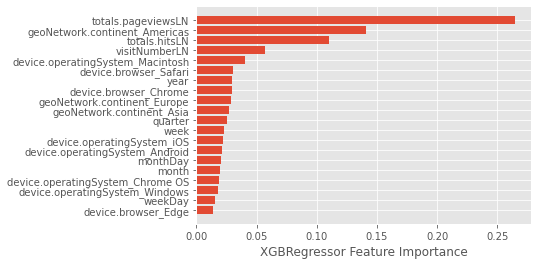

In [208]:
sorted_idx = resampled_model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx][-20:], resampled_model.feature_importances_[sorted_idx][-20:])
plt.xlabel("XGBRegressor Feature Importance")


### MLC5. Model evaluation - v2

#### a) Get predictions for train& test set - v2

In [209]:
train_predictions = pd.DataFrame(resampled_model.predict(X_train_s), index=X_train_s.index, columns=['Prediction'])
test_predictions = pd.DataFrame(resampled_model.predict(X_test_s), index=X_test_s.index, columns=['Prediction'])

In [210]:
results_df_s_train = y_train_s.join(train_predictions)
results_df_s_test = y_test_s.join(test_predictions)

In [211]:
results_df_s_test[results_df_s_test["totals.transactionRevenueLN"]>0].describe()

,totals.transactionRevenueLN,Prediction
count,388.000000,388.000000
mean,3.972204,2.244128
std,1.130644,1.049611
min,0.916291,0.013610
25%,3.238968,1.489172
50%,3.853643,2.320639
75%,4.574376,3.080690
max,9.068642,4.541855


#### b) Evaluation metrics

In [212]:
results_df_s_train.columns = ['Target', 'Prediction']
results_df_s_test.columns = ['Target', 'Prediction']

In [213]:
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(results_df_s_test.Target, results_df_s_test.Prediction))

Coefficient of determination: 0.55


In [214]:
mse_train = mean_squared_error(results_df_s_train.Target, results_df_s_train.Prediction)
rmse_train = np.sqrt(mse_train)
mae_train =  mean_absolute_error(results_df_s_train.Target, results_df_s_train.Prediction)

mse = mean_squared_error(results_df_s_test.Target, results_df_s_test.Prediction)
rmse = np.sqrt(mse)
mae =  mean_absolute_error(results_df_s_test.Target, results_df_s_test.Prediction)

In [215]:
print('TRAIN: MSE: {} - RMSE: {} - MAE: {}'.format(mse_train, rmse_train, mae_train))
print('TEST: MSE: {} - RMSE: {} - MAE: {}'.format(mse, rmse, mae))

TRAIN: MSE: 0.27451842761715817 - RMSE: 0.5239450616402049 - MAE: 0.1620278693411584
TEST: MSE: 0.34846411643462233 - RMSE: 0.5903084925991006 - MAE: 0.17304358122850777


In [216]:
mse_train = mean_squared_error(results_df_s_train[results_df_s_train.Target>0].Target, results_df_s_train[results_df_s_train.Target>0].Prediction)
rmse_train = np.sqrt(mse_train)
mae_train =  mean_absolute_error(results_df_s_train[results_df_s_train.Target>0].Target, results_df_s_train[results_df_s_train.Target>0].Prediction)

mse = mean_squared_error(results_df_s_test[results_df_s_test.Target>0].Target, results_df_s_test[results_df_s_test.Target>0].Prediction)
rmse = np.sqrt(mse)
mae =  mean_absolute_error(results_df_s_test[results_df_s_test.Target>0].Target, results_df_s_test[results_df_s_test.Target>0].Prediction)

In [217]:
print('TRAIN: MSE: {} - RMSE: {} - MAE: {}'.format(mse_train, rmse_train, mae_train))
print('TEST: MSE: {} - RMSE: {} - MAE: {}'.format(mse, rmse, mae))

TRAIN: MSE: 3.3475993298136553 - RMSE: 1.829644591119722 - MAE: 1.538602783796469
TEST: MSE: 4.876572387258077 - RMSE: 2.208296263470569 - MAE: 1.840307614560263


<AxesSubplot:xlabel='Target', ylabel='Prediction'>

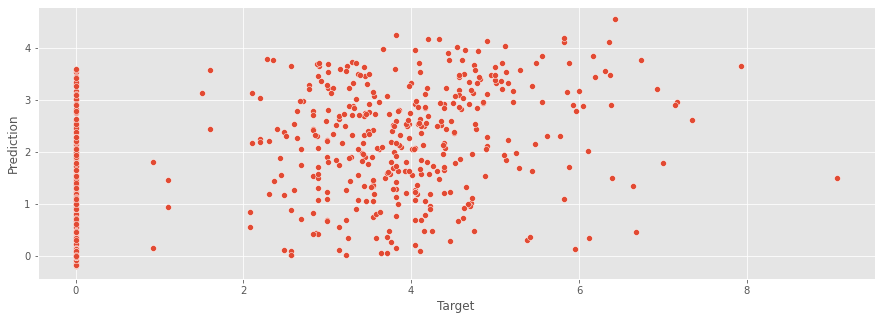

In [218]:
plt.figure(figsize=(15,5))
sns.scatterplot(
    data = results_df_s_test,
    x = 'Target',
    y =  'Prediction'
)

### MLC5. Model evaluation (final comparison)

#### Evaluation over validation set

In [219]:
val_predictions_linear = pd.DataFrame(reg_model.predict(df_val_X), index=df_val_X.index, columns=['Prediction1'])
val_predictions_first = pd.DataFrame(first_model.predict(df_val_X), index=df_val_X.index, columns=['Prediction2'])
val_predictions = pd.DataFrame(resampled_model.predict(df_val_X), index=df_val_X.index, columns=['Prediction3'])

In [220]:
val_results_df = df_val_y.join(val_predictions_linear)
val_results_df = val_results_df.join(val_predictions_first)
val_results_df = val_results_df.join(val_predictions)
val_results_df = val_results_df.applymap(lambda x: max(x,0))



In [221]:
val_results_df.head()

,totals.transactionRevenueLN,Prediction1,Prediction2,Prediction3
sessionId,,,,
0000436683523507380_1500989127,0.0,0.323730,0.037580,0.126604
0000572434142265465_1500605115,0.0,0.170212,0.029632,0.058441
0000884932399915132_1499010813,0.0,0.218712,0.010816,0.028821
0001285462512259769_1498822609,0.0,0.000000,0.008646,0.006145
0001348344294054462_1496675184,0.0,0.000000,0.014490,0.030819


In [222]:
print(val_results_df[val_results_df["totals.transactionRevenueLN"]>0]["totals.transactionRevenueLN"].mean())
print(val_results_df[val_results_df["totals.transactionRevenueLN"]>0].Prediction1.mean())
print(val_results_df[val_results_df["totals.transactionRevenueLN"]>0].Prediction2.mean())
print(val_results_df[val_results_df["totals.transactionRevenueLN"]>0].Prediction3.mean())

3.921629002489499
0.4516183208945571
0.8820505802818753
2.006267197201929


In [223]:
print(val_results_df[val_results_df["totals.transactionRevenueLN"]==0]["totals.transactionRevenueLN"].mean())
print(val_results_df[val_results_df["totals.transactionRevenueLN"]==0].Prediction1.mean())
print(val_results_df[val_results_df["totals.transactionRevenueLN"]==0].Prediction2.mean())
print(val_results_df[val_results_df["totals.transactionRevenueLN"]==0].Prediction3.mean())

0.0
0.08027953876672463
0.0404717467047839
0.09432292656631394


In [224]:
val_results_df.columns = ['Target', 'Prediction1','Prediction2', 'Prediction3']

In [225]:
mse1 = mean_squared_error(val_results_df.Target, val_results_df.Prediction1)
rmse1 = np.sqrt(mse1)
mae1 =  mean_absolute_error(val_results_df.Target, val_results_df.Prediction1)

mse2 = mean_squared_error(val_results_df.Target, val_results_df.Prediction2)
rmse2 = np.sqrt(mse2)
mae2 =  mean_absolute_error(val_results_df.Target, val_results_df.Prediction2)

mse3 = mean_squared_error(val_results_df.Target, val_results_df.Prediction3)
rmse3 = np.sqrt(mse3)
mae3 =  mean_absolute_error(val_results_df.Target, val_results_df.Prediction3)

In [226]:
print('MODEL1: MSE: {} - RMSE: {} - MAE: {}'.format(mse1, rmse1, mae1))
print('MODEL2: MSE: {} - RMSE: {} - MAE: {}'.format(mse2, rmse2, mae2))
print('MODEL3: MSE: {} - RMSE: {} - MAE: {}'.format(mse3, rmse3, mae3))

MODEL1: MSE: 0.21326808485361498 - RMSE: 0.4618095763987739 - MAE: 0.12983653180221486
MODEL2: MSE: 0.17756121699630703 - RMSE: 0.4213801336042161 - MAE: 0.0843312808949503
MODEL3: MSE: 0.2092674058397608 - RMSE: 0.45745754539602995 - MAE: 0.12143495148601839


In [227]:
mse1 = mean_squared_error(val_results_df[val_results_df.Target>0].Target, val_results_df[val_results_df.Target>0].Prediction1)
rmse1 = np.sqrt(mse1)
mae1 =  mean_absolute_error(val_results_df[val_results_df.Target>0].Target, val_results_df[val_results_df.Target>0].Prediction1)

mse2 = mean_squared_error(val_results_df[val_results_df.Target>0].Target, val_results_df[val_results_df.Target>0].Prediction2)
rmse2 = np.sqrt(mse2)
mae2 =  mean_absolute_error(val_results_df[val_results_df.Target>0].Target, val_results_df[val_results_df.Target>0].Prediction2)

mse3 = mean_squared_error(val_results_df[val_results_df.Target>0].Target, val_results_df[val_results_df.Target>0].Prediction3)
rmse3 = np.sqrt(mse3)
mae3 =  mean_absolute_error(val_results_df[val_results_df.Target>0].Target, val_results_df[val_results_df.Target>0].Prediction3)

In [228]:
print('MODEL1: MSE: {} - RMSE: {} - MAE: {}'.format(mse1, rmse1, mae1))
print('MODEL2: MSE: {} - RMSE: {} - MAE: {}'.format(mse2, rmse2, mae2))
print('MODEL3: MSE: {} - RMSE: {} - MAE: {}'.format(mse3, rmse3, mae3))

MODEL1: MSE: 13.231902126008222 - RMSE: 3.6375681610119996 - MAE: 3.470010681594943
MODEL2: MSE: 10.489944291228637 - RMSE: 3.2388183479825843 - MAE: 3.0404929313612983
MODEL3: MSE: 5.234020329719469 - RMSE: 2.2877981400725607 - MAE: 1.9488033860574892
